In [1]:
import matplotlib.image as mpimg
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
%matplotlib inline

orient = 18
pix_per_cell = 8
cell_per_block = 2
spatial = 32
hist_bins = 32
colorspace = 'RGB2YCrCb' #'RGB'
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
# saving model
filename1 = 'vd-linearsvc.pkl'
filename2 = 'vd-xscaler.pkl'

In [ ]:


xmin = 0
xmax = 1
ymin = 2
ymax = 3
Frame = 4
Label = 5

udacity_data_base = 'object-detection-crowdai/'

lines = [] 
with open(udacity_data_base + 'labels.csv') as csvfile:
    print('read csv file - labels.csv')
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

        
#print(lines[0])
#remove header
lines.pop(0)        

firstline = lines[1]
print(firstline)
#print(firstline[ymin],firstline[ymax],firstline[xmin],firstline[xmax])

image = cv2.imread(udacity_data_base + firstline[Frame])
#plt.imshow(image)
#print(image.shape)
#plt.figure()
#plt.imshow(image[int(firstline[ymax]):int(firstline[ymin]), int(firstline[xmax]): int(firstline[xmin])])
plt.imshow(image[int(firstline[ymin]):int(firstline[ymax]), int(firstline[xmin]): int(firstline[xmax])])
#plt.imshow(image[644:905, 533:785])images

cars = []
notcars = []

count = 0
for line in lines:
    #print(line)
    image = cv2.imread(udacity_data_base + line[Frame])
    
    if ymax > ymin:
        y1 = ymin
        y2 = ymax
    else:
        y1 = ymax
        y2 = ymin

    if xmax > xmin:
        x1 = xmin
        x2 = xmax
    else:
        x1 = xmax
        x2 = xmin
        
    image = image[int(line[y1]):int(line[y2]), int(line[x1]): int(line[x2])]

    if line[Label] == 'Car':
        cars.append(image)
    else:
        notcars.append(image)
    count += 1
print('done processing ', count, ' lines')

read csv file - labels.csv
['89', '551', '291', '680', '1479498371963069978.jpg', 'Car', 'http://crowdai.com/images/Wwj-gorOCisE7uxA/visualize']


In [2]:
#helper functions
def convert_color(img, conv):
    
    if conv == 'RGB':
        return np.copy(img)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


## HOG Classifier

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def extract_hog_features(img, hog_channel, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(img.shape[2]):
            hog_features.append(get_hog_features(img[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=vis, feature_vec=feature_vec))
        hog_features = np.ravel(hog_features) 
        return hog_features
    else:
        if vis == True:
            hog_features, out_img = get_hog_features(img[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=vis, feature_vec=feature_vec)

            return hog_features, out_img       
        else:
            hog_features = get_hog_features(img[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=vis, feature_vec=feature_vec)

            return hog_features

In [4]:

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(image, cspace='RGB', spatial_size=(16,16),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):

    # apply color conversion if other than 'RGB'
    feature_image = convert_color(image, cspace)  
    
    # Apply bin_spatial() to get spatial color features
    #print('spatial_size',spatial_size)
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins)

    hog_features = extract_hog_features(feature_image, hog_channel, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True)

    # Return list of feature vectors
    return np.concatenate((spatial_features, hist_features, hog_features))

## Train the classifier

In [5]:
car_features = []
notcar_features = []

#vehicle
print('read vehicles')
files = glob.glob('vehicles/*/*.png')

for file in files:
    image = cv2.imread(file)
    #print(img.shape)
    all_features = extract_features(image, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
    car_features.append(all_features)

#non vehicle   
print('read non-vehicles')
files = glob.glob('non-vehicles/*/*.png')

for file in files:
    image = cv2.imread(file)
    all_features = extract_features(image, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
    notcar_features.append(all_features)

print('stack')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
print('My SVC predicts: ', svc.predict(X_test), 'For these',len(X_test), 'labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', len(X_test),'labels with SVC')

# now you can save it to a file
joblib.dump(svc, filename1)
joblib.dump(X_scaler, filename2)

# and later you can load it
#clf = joblib.load('vd-linearsvc.pkl')

read vehicles
read non-vehicles
stack
Feature vector length: 13752
6.98 Seconds to train SVC...
Test Accuracy of SVC =  0.9944
My SVC predicts:  [ 1.  1.  1. ...,  1.  1.  0.] For these 3552 labels:  [ 1.  1.  1. ...,  1.  1.  0.]
0.05161 Seconds to predict 3552 labels with SVC


['vd-xscaler.pkl']

(720, 1280, 3)


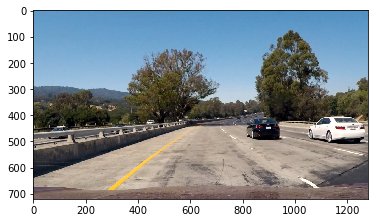

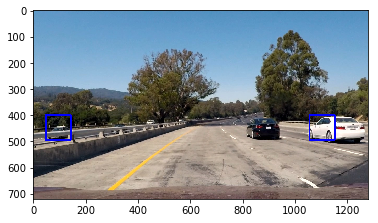

In [99]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline 

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    #print('yspan', yspan)
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    #print('nx_windows', nx_windows)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    #print('ny_windows', ny_windows)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            #print('starty',starty)
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space, 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    #print(color_space)
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, cspace=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
        #print(features)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

ystart = 400
ystop = 656
scale = 1.5

image = mpimg.imread('test_images/test1.jpg')
print(image.shape)
plt.imshow(image)
plt.figure()

spatial_size = (spatial, spatial)
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255
y_start_stop = [ystart, ystop]
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
#print(windows)
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)                       
#print(hot_windows)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


In [90]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


(720, 1280, 3)


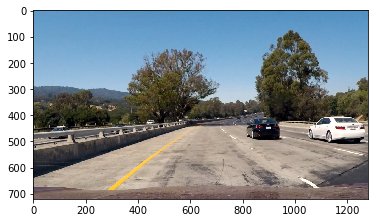

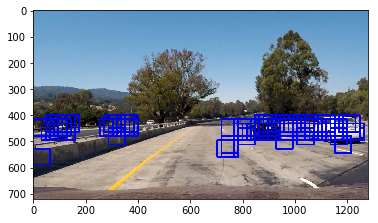

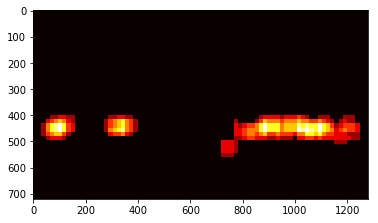

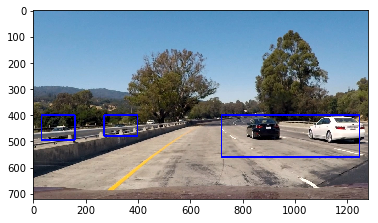

In [96]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial, hist_bins):
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #print('hog_features', hog_features.shape)
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)


            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            #print(subimg.shape)

            #check for heat
            #heat = np.zeros_like(img[:,:,0]).astype(np.float)

            #box_list = []
            #box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            # Add heat to each box in box list
            #heat = add_heat(heat,box_list)
            #print('heat', heat)
    
            # Apply threshold to help remove false positives
            #heat = apply_threshold(heat,1)
            #print('heat', heat)

            # Visualize the heatmap when displaying    
            #heatmap = np.clip(heat, 0, 255)

            # Find final boxes from heatmap using label function
            #labels = label(heatmap)
            #if labels[1] > 0 :
            #    print('labels', labels[1])
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=(spatial, spatial))
            #print('spatial_features', spatial_features.shape)
            hist_features = color_hist(subimg, nbins=hist_bins)
            #print('hist_features', hist_features.shape)

            #img_features = np.hstack((spatial_features, hist_features, hog_features))
            img_features = np.concatenate((spatial_features, hist_features, hog_features))
            # Scale features and make a prediction
            test_features = X_scaler.transform(img_features.reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return bboxes
    
ystart = 400
ystop = 656
scale = 1

img = mpimg.imread('test_images/test1.jpg')
print(img.shape)
plt.imshow(img)

#load classifier
svc = joblib.load(filename1)
X_scaler = joblib.load(filename2)


bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial, hist_bins)
draw_img = np.copy(img)
for bbox in bboxes:
    cv2.rectangle(draw_img,bbox[0],bbox[1],(0,0,255),6)
    
plt.figure()
plt.imshow(draw_img)

heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,bboxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

plt.figure()
plt.imshow(heatmap, cmap='hot')

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

plt.figure()
plt.imshow(draw_img)
